In [1]:
import pandas as pd
import numpy as np

### Read the data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print train.shape
print test.shape

(260753, 299)
(173836, 298)


In [4]:
train[:3]

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,...,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,...,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,...,15,18,-1,21,-1,11,-1,8,N,NJ


### Prepare the data

In [5]:
def prepare_features(data):
    data.fillna(-1, inplace=True)
    
    data['Date'] = pd.to_datetime(pd.Series(data['Original_Quote_Date']))
    data['Day'] = data.Date.apply(lambda x: x.day)
    data['Month'] = data.Date.apply(lambda x: x.month)
    data['Year'] = data.Date.apply(lambda x: x.year)
    data['DayOfYear'] = data.Date.map(lambda x: x.dayofyear)
    data['WeekOfYear'] = data.Date.apply(lambda x: x.weekofyear)
    
    data.drop(['Original_Quote_Date', 'QuoteNumber', 'Date'], axis=1, inplace=True)

In [6]:
prepare_features(train)
prepare_features(test)

In [7]:
train[:3]

,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,...,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,Day,Month,Year,DayOfYear,WeekOfYear
0,0,B,23,0.9403,0.0006,965,1.0200,N,17,23,...,18,-1,10,N,CA,16,8,2013,228,33
1,0,F,7,1.0006,0.0040,548,1.2433,N,6,8,...,17,-1,20,N,NJ,22,4,2014,112,17
2,0,F,7,1.0006,0.0040,548,1.2433,N,7,12,...,11,-1,8,N,NJ,25,8,2014,237,35


In [8]:
# Replace labels with floats
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

for f in test.columns:
    if train[f].dtype=='object':
        lbl_enc.fit(list(train[f])+list(test[f]))
        train[f] = lbl_enc.transform(list(train[f].values))
        test[f] = lbl_enc.transform(list(test[f].values))

### Try Random Forest 

In [9]:
from sklearn.cross_validation import train_test_split
x_tr, x_cv, y_tr, y_cv = train_test_split(train[test.columns], train.QuoteConversion_Flag, test_size = 0.01,  random_state = 42)

In [11]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

rf = RandomForestRegressor(
    n_estimators=10,
    n_jobs=3,
    random_state=42,
    oob_score=True
)
rf.fit(x_tr, y_tr)

Wall time: 1min 50s


C:\Program Files\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:659: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [12]:
pred_RF = rf.predict(x_cv)
roc_auc_score(y_cv, pred_RF)

0.94740867589950806

In [13]:
pred_RF[:10]

array([ 0.7,  1. ,  0. ,  1. ,  0. ,  0.2,  0. ,  0.2,  0. ,  0. ])

The best: 0.96270111925965252

In [64]:
%matplotlib inline
import matplotlib as mpl
import pylab as plt
import scipy

Feature ranking:


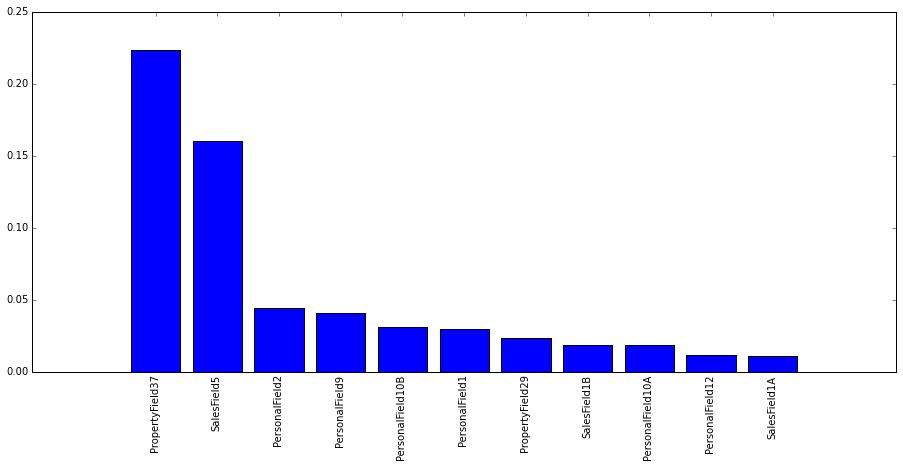

In [71]:
# Show feature importances
importances = rf.feature_importances_
low_value = 0.010
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
inds = [i for i in indices if importances[i] > low_value]

print("Feature ranking:")

labels = [list(test.columns)[i] for i in indices.tolist() if importances[i] > low_value]
x = scipy.array(xrange(len(inds)))
y = scipy.array(importances[inds])
f = plt.figure(figsize=(12,5))
ax = f.add_axes([1, 1, 1, 1])
ax.bar(x, y, align='center')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
f.show()

### Try XGB 

In [13]:
# Set params

params = {"objective": "binary:logistic",
          "booster": "gbtree",
          "eval_metric": "auc",
          "eta": 0.023,
          "max_depth": 6,
          "subsample": 0.83,
          "colsample_bytree": 0.77,
          "silent": 1
          }
num_trees = 1800
stop = 30

In [14]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_tr.values, y_tr)
dvalid = xgb.DMatrix(x_cv.values, y_cv)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=stop, verbose_eval=True)

Will train until train error hasn't decreased in 30 rounds.
[0]	eval-auc:0.930956	train-auc:0.930707
[1]	eval-auc:0.938780	train-auc:0.938764
[2]	eval-auc:0.938652	train-auc:0.938422
[3]	eval-auc:0.941041	train-auc:0.941825
[4]	eval-auc:0.942565	train-auc:0.942171
[5]	eval-auc:0.940928	train-auc:0.940695
[6]	eval-auc:0.944217	train-auc:0.944178
[7]	eval-auc:0.944316	train-auc:0.944343
[8]	eval-auc:0.944220	train-auc:0.944484
[9]	eval-auc:0.944318	train-auc:0.944376
[10]	eval-auc:0.945005	train-auc:0.945242
[11]	eval-auc:0.945956	train-auc:0.945806
[12]	eval-auc:0.946570	train-auc:0.947175
[13]	eval-auc:0.947242	train-auc:0.947577
[14]	eval-auc:0.947182	train-auc:0.947489
[15]	eval-auc:0.947330	train-auc:0.947887
[16]	eval-auc:0.947751	train-auc:0.948072
[17]	eval-auc:0.948042	train-auc:0.948280
[18]	eval-auc:0.947946	train-auc:0.948256
[19]	eval-auc:0.947879	train-auc:0.948233
[20]	eval-auc:0.948363	train-auc:0.948645
[21]	eval-auc:0.948300	train-auc:0.949079
[22]	eval-auc:0.948326	tra

In [15]:
dtest = xgb.DMatrix(test.as_matrix())
XGB = gbm.predict(dtest)
indices = XGB < 0
XGB[indices] = 0

In [16]:
ids = pd.read_csv('data/test.csv').QuoteNumber

In [17]:
submit = pd.read_csv('data/sample_submission.csv')
submit.QuoteConversion_Flag = XGB
submit.to_csv('submit.csv', index=False)